In [ ]:
# Install datasets
!pip install datasets

In [ ]:
#imports

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import pickle
import json
import os


In [ ]:
# Load dataset
dataset = load_dataset("boolq", split="train[:10000]")

In [ ]:
# lets see dataset
for k in dataset:
    print(f"passage :{k['passage']}")
    print(f"question :{k['question']}")
    print(f"answer :{k['answer']}")

    break

passage :Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.
question :do iran and afghanistan speak the same language
answer :True


In [ ]:
#building custom tokenizer
class TextDataset(Dataset):
    def __init__(self, data, tokenizer=None, max_length=128):
        self.data = data
        self.max_length = max_length
        # Simple tokenizer: word to index
        if tokenizer is None:
            all_words = set()
            for item in data:
                all_words.update(item['question'].lower().split())
            self.vocab = {word: idx+1 for idx, word in enumerate(sorted(all_words))}
            self.vocab['<PAD>'] = 0
        else:
            self.vocab = tokenizer

    def tokenize(self, text):
        words = text.lower().split()[:self.max_length]
        indices = [self.vocab.get(word, 0) for word in words]
        # Pad to max_length
        indices += [0] * (self.max_length - len(indices))
        return torch.LongTensor(indices)  # IMPORTANT: LongTensor for embedding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        x = self.tokenize(item['question'])
        y = int(item['answer'])  # 0 or 1
        return x, y

# Create dataset
text_dataset = TextDataset(dataset)
vocab_size = len(text_dataset.vocab)
train_Data_loader = DataLoader(text_dataset, batch_size=32, shuffle=True)

print(f"Vocabulary size: {vocab_size}")
print(f"Dataset size: {len(text_dataset)}")

# Verify data types
sample_x, sample_y = text_dataset[0]
print(f"sample tokenized x :{sample_x}")
print(f"sample tokenized y :{sample_y}")
print(f"Sample x dtype: {sample_x.dtype}, shape: {sample_x.shape}")
print(f"Sample y dtype: {sample_y}, type: {type(sample_y)}")

Vocabulary size: 9237
Dataset size: 9427
sample tokenized x :tensor([2606, 4371,  482,  332, 7751, 8286, 7235, 4745,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
sample tokenized y :1
Sample x dtype: torch.int64, shape: torch.Size([128])
Sample

In [ ]:
#class for Doubaly matrix constraint
class SinkhornKnopp(nn.Module):
    """
    Sinkhorn-Knopp algorithm for doubly stochastic matrix normalization.

    Iteratively normalizes rows and columns of a square matrix so that:
    - All entries are non-negative
    - Each row sums to 1
    - Each column sums to 1

    Args:
        num_iters (int): Number of normalization iterations (default: 20)
        eps (float): Small constant for numerical stability (default: 1e-8)
    """
    def __init__(self, num_iters: int = 20, eps: float = 1e-8):
        super().__init__()

        assert num_iters > 0, f"num_iters must be positive, got {num_iters}"
        assert eps > 0, f"eps must be positive, got {eps}"

        self.num_iters = num_iters
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (n, n) - must be square matrix

        Returns:
            Doubly stochastic matrix of shape (n, n)
        """
        # Validate input
        if x.dim() != 2:
            raise ValueError(f"Input must be 2D matrix, got shape {x.shape}")

        if x.shape[0] != x.shape[1]:
            raise ValueError(f"Input must be square matrix, got shape {x.shape}")

        # Make all entries positive
        x = torch.exp(x)

        # Iteratively normalize rows and columns
        for i in range(self.num_iters):
            # Normalize rows to sum to 1
            row_sums = x.sum(dim=1, keepdim=True)
            x = x / (row_sums + self.eps)

            # Normalize columns to sum to 1
            col_sums = x.sum(dim=0, keepdim=True)
            x = x / (col_sums + self.eps)

        # Verify doubly stochastic property (with warning if violated)
        with torch.no_grad():
            row_sums = x.sum(dim=1)
            col_sums = x.sum(dim=0)

            max_row_dev = (row_sums - 1.0).abs().max().item()
            max_col_dev = (col_sums - 1.0).abs().max().item()

            if max_row_dev > 0.01 or max_col_dev > 0.01:
                warnings.warn(
                    f"Doubly stochastic constraint not well satisfied: "
                    f"max row deviation={max_row_dev:.6f}, "
                    f"max col deviation={max_col_dev:.6f}. "
                    f"Consider increasing num_iters (current: {self.num_iters})"
                )

        return x



In [ ]:
#mHC class
class mHCLayer(nn.Module):
    """
    Simple mHC Layer - Multi-stream residual connections

    Args:
        dim: Feature dimension
        num_streams: Number of parallel streams (default: 4)

    Input: (batch, num_streams, dim)
    Output: (batch, num_streams, dim)
    """
    def __init__(self, dim: int, num_streams: int = 4,num_sk_iters :int=10,eps: float = 1e-8,manifold_constrained: bool =True):
        super().__init__()
        self.dim = dim
        self.num_streams = num_streams
        self.manifold_constrained=manifold_constrained

        # Sinkhorn-Knopp module for H_res
        self.sinkhorn = SinkhornKnopp(num_iters=num_sk_iters, eps=eps)

        # Learnable routing weights (we'll normalize them)
        self.H_res = nn.Parameter(torch.randn(num_streams, num_streams))
        self.H_pre = nn.Parameter(torch.randn(1, num_streams))
        self.H_post = nn.Parameter(torch.randn(1, num_streams))

        # Initialize close to identity/uniform
        nn.init.xavier_uniform_(self.H_res)
        nn.init.xavier_uniform_(self.H_pre)
        nn.init.xavier_uniform_(self.H_post)

    def get_constrained_matrices(self,manifold_constrained=True):
        """
        Apply constraints to learnable matrices.

        Returns:
            H_res: (num_streams, num_streams) - doubly stochastic
            H_pre: (1, num_streams) - non-negative [0, 1]
            H_post: (1, num_streams) - non-negative [0, 2]
        """
        if manifold_constrained:
          # H_res: Doubly stochastic via Sinkhorn-Knopp
          H_res = self.sinkhorn(self.H_res)

          # H_pre: Non-negative [0, 1] via sigmoid
          H_pre = torch.sigmoid(self.H_pre)

          # H_post: Non-negative [0, 2] via scaled sigmoid
          H_post = 2.0 * torch.sigmoid(self.H_post)

          return H_res, H_pre, H_post

        else:
          return self.H_res, self.H_pre, self.H_post

    def get_matrices(self):
      return self.H_res, self.H_pre, self.H_post
    def forward(self, x_l, layer_obj):
        """
        Args:
            x_l: (batch, num_streams, dim)
            layer_obj: A layer that takes (batch, dim) -> (batch, dim)

        Returns:
            x_next: (batch, num_streams, dim)
        """
        batch_size = x_l.shape[0]

        # Get normalized weights
        H_res, H_pre, H_post = self.get_constrained_matrices(manifold_constrained= self.manifold_constrained)

        # 1. Mix streams: weighted combination of all streams
        #[b,num_streams,dim] = [num_streams,num_streams] @ [b,num_streams,dim]
        mixed = H_res @ x_l

        # 2. Aggregate streams for layer input
        #[b,dim]=[b,1,dim].squeeze(1)=[1,num_streams]@[b,num_streams,dim]
        layer_input =  (H_pre @ x_l).squeeze(1)

        # 3. Process through the layer
        #[b,dim]=[b,dim]
        layer_output = layer_obj(layer_input)

        # 4. Distribute output back to streams
        #[] = [1,num_streams].T @ [b,dim].unsqueeze(1)
        #[b,num_streams,dim] = [num_streams,1]@[b,1,dim]
        contributions = (H_post.T @ layer_output.unsqueeze(1))

        # 5. Residual connection
        #[b,num_streams,dim]  = [b,num_streams,dim] + [[b,num_streams,dim]]
        x_next = mixed + contributions

        return x_next

In [ ]:
# Test out mHC layer
# Helper function to create multi-stream input
def create_multi_stream_input(x, num_streams=4):
    """
    Convert single tensor to multi-stream format

    Args:
        x: (batch, dim)
        num_streams: Number of streams

    Returns:
        (batch, num_streams, dim)
    """
    return x.unsqueeze(1).expand(-1, num_streams, -1)


# Example usage
if __name__ == "__main__":
    # Simple demo
    batch_size = 2
    dim = 512
    num_streams = 4

    # Create a simple layer (like attention or FFN)
    processing_layer = nn.Linear(dim, dim)

    # Create mHC layer
    mhc = mHCLayer(dim=dim, num_streams=num_streams)

    # Create input
    x = torch.randn(batch_size, dim)
    x_multi_stream = create_multi_stream_input(x, num_streams)

    print(f"Input shape: {x_multi_stream.shape}")

    # Forward pass
    output = mhc(x_multi_stream, processing_layer)

    print(f"Output shape: {output.shape}")
    print("mHC layer works!")

Input shape: torch.Size([2, 4, 512])
Output shape: torch.Size([2, 4, 512])
mHC layer works!


In [ ]:
#lets build a basic model with and without manifold constrain

class DeepReasoningNet(nn.Module):
    def __init__(self, vocab_size=10000, embed_dim=256, hidden_dim=512,
                 num_layers=30, num_sk_iters=40,use_mhc=False):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.proj = nn.Linear(embed_dim, hidden_dim)  # Project to hidden_dim
        self.use_mhc = use_mhc

        if use_mhc:
            self.layers = nn.ModuleList([
                mHCLayer(dim=hidden_dim, num_streams=4,num_sk_iters=num_sk_iters,manifold_constrained=True)
                for _ in range(num_layers)
            ])
            self.processing_layers = nn.ModuleList([
                nn.Linear(hidden_dim, hidden_dim)
                for _ in range(num_layers)
            ])
        else:
            self.layers = nn.ModuleList([
                mHCLayer(dim=hidden_dim, num_streams=4,num_sk_iters=num_sk_iters,manifold_constrained=False)
                for _ in range(num_layers)
            ])
            self.processing_layers = nn.ModuleList([
                nn.Linear(hidden_dim, hidden_dim)
                for _ in range(num_layers)
            ])

        self.classifier = nn.Linear(hidden_dim, 2)
        self.num_layers = num_layers

    def create_multi_stream_input(self,x, num_streams=4):
        # x: (batch, hidden_dim)
        batch_size, dim = x.shape
        x = x.unsqueeze(1).expand(-1, num_streams, -1)  # (batch, num_streams, hidden_dim)
        return x

    def forward(self, x):
        # x: (batch, seq_len) - LongTensor with token indices
        x = self.embed(x)  # (batch, seq_len, embed_dim)
        x = x.mean(dim=1)  # (batch, embed_dim)
        x = self.proj(x)   # (batch, hidden_dim)
        x = F.relu(x)      # (batch, hidden_dim)

        x = self.create_multi_stream_input(x, num_streams=4)
        for mhc_layer, proc_layer in zip(self.layers, self.processing_layers):
            #[batch,num_streams,hidden_dim] = [batch,num_streams,hidden_dim],[hidden_dim,hidden_dim]
            x = mhc_layer(x, proc_layer)
            #[batch,num_streams,dim]
            x = F.relu(x)
        #[batch, hidden_dim] = [batch,hidden_dim]= [batch,num_streams,hidden_dim].mean(dim=1)
        x = x.mean(dim=1)
        #[batch, 2] = [batch, hidden_dim] @[hidden_dim, 2]
        return self.classifier(x)

In [ ]:
#Lets train this model while storing gradient norms for each processing layer

def track_gradient_flow(model, train_loader, epochs=10, seed=42, model_save_path="model.pth"):
    """Track gradients and matrix changes across layers during training"""
    # Set seed for reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Fix for Triton error in Colab
    os.environ['TRITON_PTXAS_PATH'] = '/usr/bin/ptxas'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    gradient_norms = {i: [] for i in range(len(model.layers))}

    # Track matrix statistics (norms, min, max)
    matrix_stats = {
        'H_res_norm': {i: [] for i in range(len(model.layers))},
        'H_pre_norm': {i: [] for i in range(len(model.layers))},
        'H_post_norm': {i: [] for i in range(len(model.layers))},
        'H_res_min': {i: [] for i in range(len(model.layers))},
        'H_res_max': {i: [] for i in range(len(model.layers))},
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for x, y in pbar:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            try:
                output = model(x)
                loss = criterion(output, y)
                loss.backward()
            except Exception as e:
                print(f"\nError during forward/backward pass: {e}")
                continue

            # Collect gradient norms for each layer
            for i, proc_layer in enumerate(model.processing_layers):
                if proc_layer.weight.grad is not None:
                    grad_norm = proc_layer.weight.grad.norm().item()
                    gradient_norms[i].append(grad_norm)
                else:
                    gradient_norms[i].append(0.0)

            optimizer.step()

            # Track matrix values (with error handling)
            try:
                for i, mhc_layer in enumerate(model.layers):
                    H_res, H_pre, H_post = mhc_layer.get_matrices()

                    # Store statistics (memory efficient)
                    matrix_stats['H_res_norm'][i].append(H_res.norm().item())
                    matrix_stats['H_pre_norm'][i].append(H_pre.norm().item())
                    matrix_stats['H_post_norm'][i].append(H_post.norm().item())
                    matrix_stats['H_res_min'][i].append(H_res.min().item())
                    matrix_stats['H_res_max'][i].append(H_res.max().item())
            except Exception as e:
                print(f"\nError tracking matrices: {e}")

            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Save model
    torch.save(model.state_dict(), model_save_path)
    print(f"\nModel saved at: {model_save_path}")

    # Save gradient norms
    gradient_norms_path = model_save_path.replace(".pth", "_gradient_norms.json")
    with open(gradient_norms_path, 'w') as f:
        json.dump(gradient_norms, f, indent=4)
    print(f"gradient_norms dict saved at: {gradient_norms_path}")

    # Save matrix stats
    matrix_stats_path = model_save_path.replace(".pth", "_matrix_stats.json")
    with open(matrix_stats_path, 'w') as f:
        json.dump(matrix_stats, f, indent=4)
    print(f"matrix_stats dict saved at: {matrix_stats_path}")

    return gradient_norms, matrix_stats, model


In [ ]:
# Helper function to visualize gradient flow of processing layer for each step.

def get_gradient_chart(grads_baseline, grads_mhc, num_layers, layer_step=10, step_cap=-1):
    # Convert string keys back to integers if needed
    grads_baseline = {int(k): v for k, v in grads_baseline.items()}
    grads_mhc = {int(k): v for k, v in grads_mhc.items()}

    # Generate layer sequence
    layer_seq = list(range(0, num_layers, layer_step)) + [num_layers - 1]
    print(f"Plotting layers: {layer_seq}")

    # Collect all gradient values to determine global y-axis limits
    all_grads = []
    for layer_idx in layer_seq:
        if layer_idx in grads_baseline and len(grads_baseline[layer_idx]) > 0:
            all_grads.extend(grads_baseline[layer_idx][:step_cap] if step_cap > 0 else grads_baseline[layer_idx])
        if layer_idx in grads_mhc and len(grads_mhc[layer_idx]) > 0:
            all_grads.extend(grads_mhc[layer_idx][:step_cap] if step_cap > 0 else grads_mhc[layer_idx])

    # Filter out zeros, NaNs, and Infs for log scale
    all_grads = [g for g in all_grads if g > 0 and np.isfinite(g)]

    if all_grads:
        y_min = min(all_grads) * 0.5
        y_max = max(all_grads) * 2.0
    else:
        print("Warning: No valid gradients found, using default limits")
        y_min, y_max = 1e-15, 1e2

    # Validate y-axis limits
    if not (np.isfinite(y_min) and np.isfinite(y_max)):
        print(f"Warning: Invalid y-axis limits (y_min={y_min}, y_max={y_max}), using defaults")
        y_min, y_max = 1e-15, 1e2

    # Plot
    plt.figure(figsize=(14, 6))

    # Baseline plot
    plt.subplot(1, 2, 1)
    for layer_idx in layer_seq:
        if layer_idx in grads_baseline and len(grads_baseline[layer_idx]) > 0:
            data = grads_baseline[layer_idx][:step_cap] if step_cap > 0 else grads_baseline[layer_idx]
            data = [max(g, 1e-15) if np.isfinite(g) else 1e-15 for g in data]
            plt.plot(data, label=f'Layer {layer_idx}', linewidth=1)

    plt.title('Baseline - Gradient Flow', fontsize=14)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Gradient Norm', fontsize=12)
    plt.legend()
    plt.yscale('log')
    plt.ylim(y_min, y_max)
    plt.grid(True, alpha=0.8)

    # mHC plot
    plt.subplot(1, 2, 2)
    for layer_idx in layer_seq:
        if layer_idx in grads_mhc and len(grads_mhc[layer_idx]) > 0:
            data = grads_mhc[layer_idx][:step_cap] if step_cap > 0 else grads_mhc[layer_idx]
            data = [max(g, 1e-15) if np.isfinite(g) else 1e-15 for g in data]
            plt.plot(data, label=f'Layer {layer_idx}', linewidth=1)

    plt.title('mHC - Gradient Flow', fontsize=14)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Gradient Norm', fontsize=12)
    plt.legend()
    plt.yscale('log')
    plt.ylim(y_min, y_max)
    plt.grid(True, alpha=0.8)

    plt.tight_layout()
    plt.savefig('gradient_flow_chart.png', dpi=500)
    plt.show()

# Visualization function for the mHc matrix
def plot_matrix_evolution(matrix_stats, num_layers,step_cap=-1, save_path='matrix_evolution.png'):
    """Plot how matrix norms evolve during training"""

    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    layer_seq=[i for i in range(0,num_layers,40)]+[num_layers -1]

    # Plot H_res norms
    for i in layer_seq:
        i=str(i)
        axes[0].plot(matrix_stats['H_res_norm'][i][:step_cap], label=f'Layer {i}', alpha=0.7)
    axes[0].set_ylabel('H_res Norm')
    axes[0].set_title(f'H_res Matrix Norms Over Training {save_path.split(".")[0]}')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)

    # Plot H_pre norms
    for i in layer_seq:
        i=str(i)
        axes[1].plot(matrix_stats['H_pre_norm'][i][:step_cap], label=f'Layer {i}', alpha=0.7)
    axes[1].set_ylabel('H_pre Norm')
    axes[1].set_title(f'H_pre Matrix Norms Over Training {save_path.split(".")[0]}')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)

    # Plot H_post norms
    for i in layer_seq:
        i=str(i)
        axes[2].plot(matrix_stats['H_post_norm'][i][:step_cap], label=f'Layer {i}', alpha=0.7)
    axes[2].set_xlabel('Training Step (x100)')
    axes[2].set_ylabel('H_post Norm')
    axes[2].set_title(f'H_post Matrix Norms Over Training {save_path.split(".")[0]}')
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Check for explosion/vanishing
    print("\nMatrix Stability Analysis:")
    for matrix_name in ['H_res_norm', 'H_pre_norm', 'H_post_norm']:
        print(f"\n{matrix_name}:")
        for i in layer_seq:
            i=str(i)
            values = matrix_stats[matrix_name][i]
            if len(values) > 0:
                initial = values[0]
                final = values[-1]
                change_ratio = final / (initial + 1e-8)

                status = "STABLE"
                if change_ratio > 10:
                    status = "EXPLODING ⚠️"
                elif change_ratio < 0.1:
                    status = "VANISHING ⚠️"

                print(f"  Layer {i}: {initial:.4f} → {final:.4f} (×{change_ratio:.2f}) - {status}")


In [ ]:
def test(num_layers=30,epochs=10,layer_step=20,step_cap=-1):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  #non_mhc model
  model_baseline = DeepReasoningNet(vocab_size=vocab_size,num_layers=num_layers,num_sk_iters=40,use_mhc=False).to(device)

  #mhc model
  model_mhc = DeepReasoningNet(vocab_size=vocab_size, num_layers=num_layers,num_sk_iters=40,use_mhc=True).to(device)


  print(f"Models created successfully on {device}")
  print(f"Baseline params: {sum(p.numel() for p in model_baseline.parameters()):,}")
  print(f"mHC params: {sum(p.numel() for p in model_mhc.parameters()):,}")

  #train baseline model
  print("training baseline model")
  model_baseline_model_norms ,baseline_model_matrix_stats,model_baseline_model= track_gradient_flow(model_baseline, train_Data_loader, epochs=epochs, seed=42,model_save_path="baseline_model.pth")

  #train mhc model
  print("training mhc model")
  mhc_model_norms ,mhc_model_matrix_stat,mhc_model= track_gradient_flow(model_mhc, train_Data_loader, epochs=epochs, seed=42,model_save_path="mhc_model.pth")


  with open('/content/baseline_model_gradient_norms.json', 'r') as f:
    model_baseline_model_norms = json.load(f)

  with open('/content/mhc_model_gradient_norms.json', 'r') as f:
      mhc_model_norms = json.load(f)

  with open('/content/baseline_model_matrix_stats.json', 'r') as f:
      baseline_model_matrix_stats = json.load(f)

  with open('/content/mhc_model_matrix_stats.json', 'r') as f:
      mhc_model_matrix_stat = json.load(f)

  get_gradient_chart(model_baseline_model_norms,mhc_model_norms,num_layers=mhc_model.num_layers,layer_step=layer_step,step_cap=step_cap)

  plot_matrix_evolution(baseline_model_matrix_stats, num_layers,step_cap=step_cap, save_path='baseline_matrix_evolution.png')

  plot_matrix_evolution(mhc_model_matrix_stat, num_layers,step_cap=step_cap, save_path='mHC_matrix_evolution.png')


Models created successfully on cuda
Baseline params: 28,765,282
mHC params: 28,765,282
training baseline model


Epoch 20/20: 100%|██████████| 295/295 [00:38<00:00,  7.74it/s, loss=0.6837]



Model saved at: baseline_model.pth
gradient_norms dict saved at: baseline_model_gradient_norms.json
matrix_stats dict saved at: baseline_model_matrix_stats.json
training mhc model


Epoch 20/20: 100%|██████████| 295/295 [06:18<00:00,  1.28s/it, loss=0.6813]



Model saved at: mhc_model.pth
gradient_norms dict saved at: mhc_model_gradient_norms.json
matrix_stats dict saved at: mhc_model_matrix_stats.json
Plotting layers: [99]


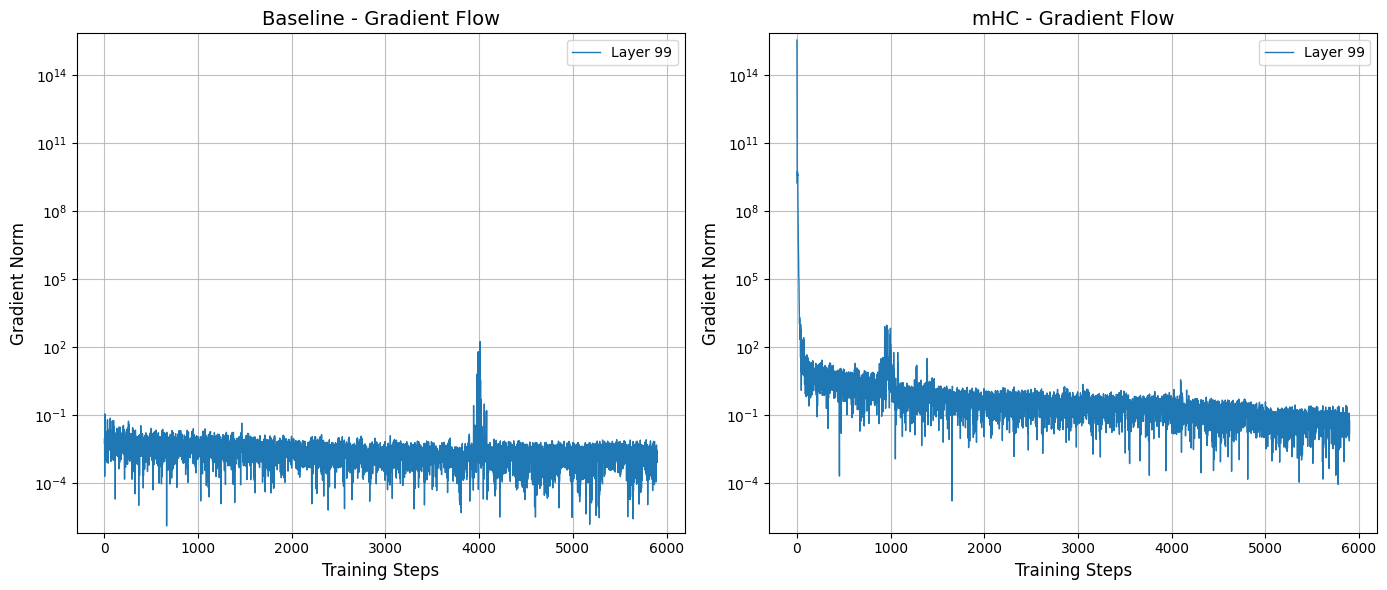

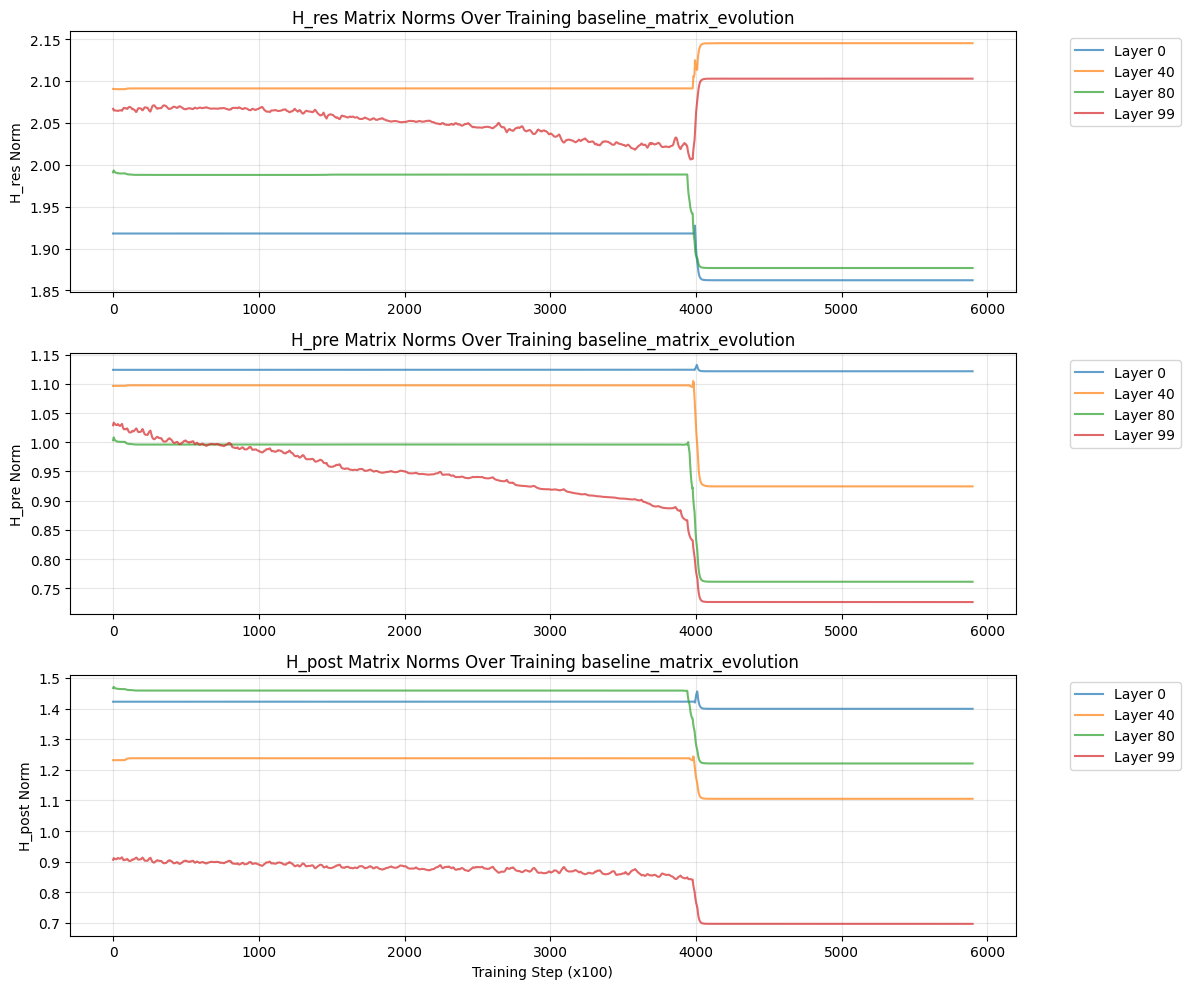


Matrix Stability Analysis:

H_res_norm:
  Layer 0: 1.9180 → 1.8622 (×0.97) - STABLE
  Layer 40: 2.0905 → 2.1451 (×1.03) - STABLE
  Layer 80: 1.9910 → 1.8768 (×0.94) - STABLE
  Layer 99: 2.0668 → 2.1027 (×1.02) - STABLE

H_pre_norm:
  Layer 0: 1.1240 → 1.1215 (×1.00) - STABLE
  Layer 40: 1.0965 → 0.9245 (×0.84) - STABLE
  Layer 80: 1.0035 → 0.7613 (×0.76) - STABLE
  Layer 99: 1.0291 → 0.7265 (×0.71) - STABLE

H_post_norm:
  Layer 0: 1.4225 → 1.3993 (×0.98) - STABLE
  Layer 40: 1.2314 → 1.1052 (×0.90) - STABLE
  Layer 80: 1.4671 → 1.2207 (×0.83) - STABLE
  Layer 99: 0.9060 → 0.6966 (×0.77) - STABLE


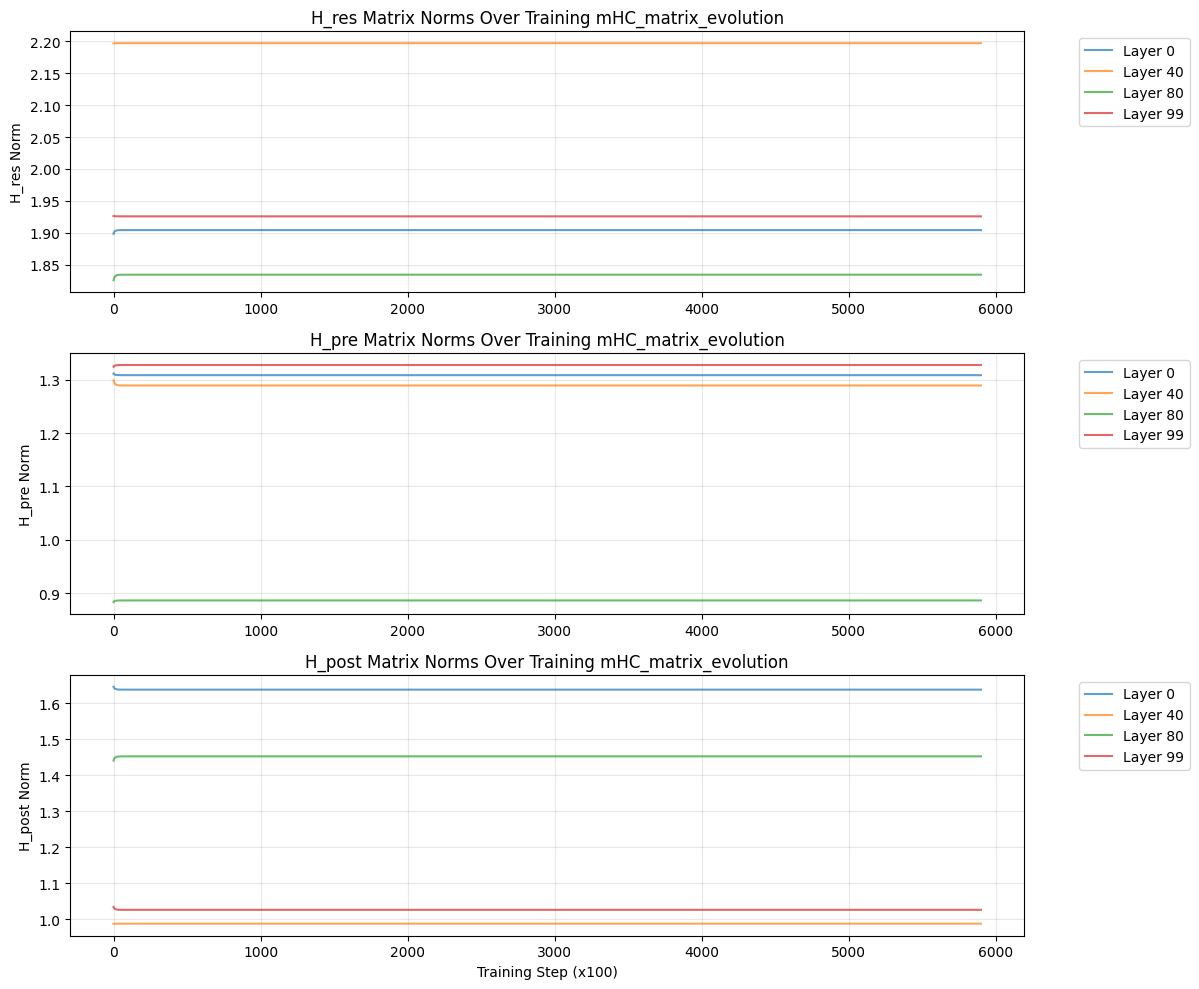


Matrix Stability Analysis:

H_res_norm:
  Layer 0: 1.8984 → 1.9042 (×1.00) - STABLE
  Layer 40: 2.1968 → 2.1973 (×1.00) - STABLE
  Layer 80: 1.8255 → 1.8342 (×1.00) - STABLE
  Layer 99: 1.9262 → 1.9257 (×1.00) - STABLE

H_pre_norm:
  Layer 0: 1.3119 → 1.3089 (×1.00) - STABLE
  Layer 40: 1.2990 → 1.2895 (×0.99) - STABLE
  Layer 80: 0.8830 → 0.8860 (×1.00) - STABLE
  Layer 99: 1.3247 → 1.3279 (×1.00) - STABLE

H_post_norm:
  Layer 0: 1.6453 → 1.6374 (×1.00) - STABLE
  Layer 40: 0.9869 → 0.9875 (×1.00) - STABLE
  Layer 80: 1.4405 → 1.4521 (×1.01) - STABLE
  Layer 99: 1.0337 → 1.0259 (×0.99) - STABLE


In [ ]:
# with sknoff inters =40
test(num_layers=100,epochs=20,layer_step=-1)

Plotting layers: [0, 40, 80, 99]


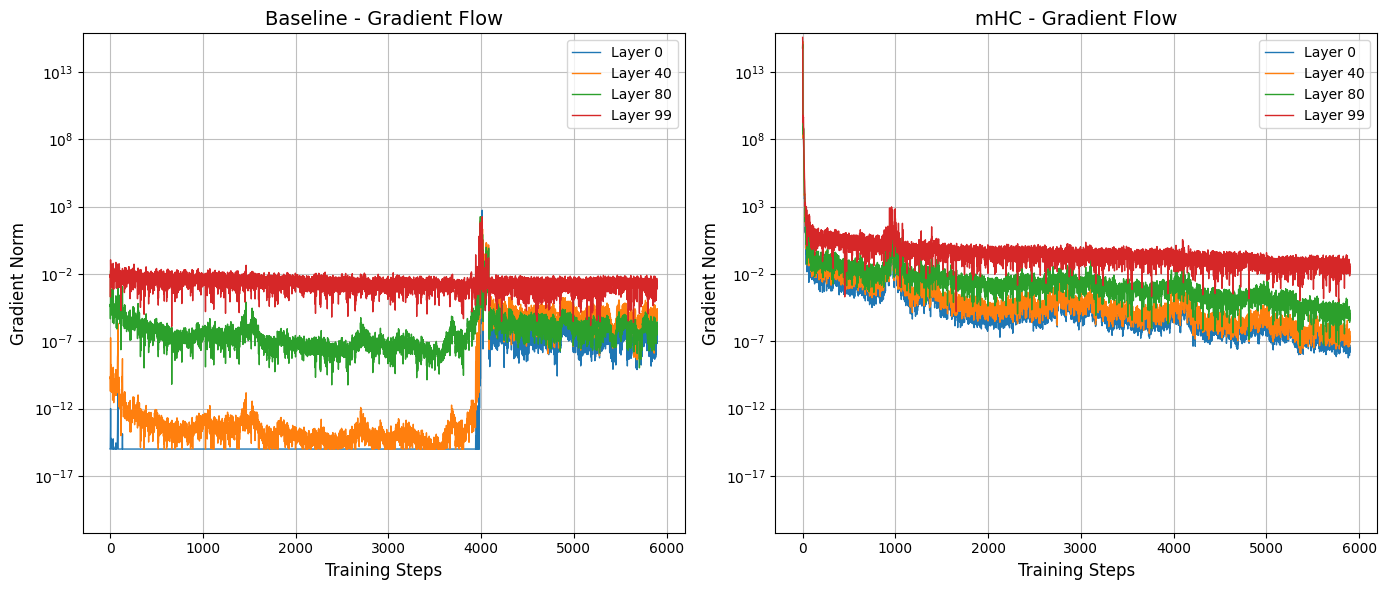

In [ ]:
with open('/content/baseline_model_gradient_norms.json', 'r') as f:
    model_baseline_model_norms = json.load(f)


with open('/content/mhc_model_gradient_norms.json', 'r') as f:
    mhc_model_norms = json.load(f)


with open('/content/baseline_model_matrix_stats.json', 'r') as f:
    baseline_model_matrix_stats = json.load(f)

with open('/content/mhc_model_matrix_stats.json', 'r') as f:
    mhc_model_matrix_stat = json.load(f)



num_layers=100
layer_step= -1
step_cap=-1

get_gradient_chart(model_baseline_model_norms,mhc_model_norms,num_layers=num_layers,layer_step=40,step_cap=step_cap)
